## CS-489 Project
### Nicholas McKillip
### Intro: 
I am using the dataset of tweets found at https://www.figure-eigt.com/data-for-everyone/.h. I am trying to predict the labelled setiment of each tweet from the words present in the tweet. I will be using Deep Learning for this tasks.

In [234]:
if (!require("keras")) install.packages("keras")
library(keras)
if (!require("tidyverse")) install.packages("tidyverse")
library(tidyverse)
if (!require("qdapRegex")) install.packages("qdapRegex")
library(qdapRegex)
if (!require("data.table")) install.packages("data.table")
library(data.table)
if (!require("caret")) install.packages("caret")
library(caret)

In [236]:
Sys.setlocale('LC_ALL','C') 

[1] "C/C/C/C/C/en_US.UTF-8"

### Loading and cleaning the dataset
We remove the that was unable to classified, as well as the second column of the data frame as it was very sparse, and phone type does not seem like it would be a useful feature anyway.

In [238]:
tweets = read.csv(file = "tweets.csv", header = TRUE, sep = ",",stringsAsFactors = FALSE)

In [240]:
tweets = tweets[-c(which(tweets$is_there_an_emotion_directed_at_a_brand_or_product == "I can't tell" )),]

In [242]:
tweets = tweets[,c(1,3)]

### Tokenization

In [244]:
max_len = 100
max_features = 20000

In [246]:
word_seq = text_tokenizer(num_words = max_features) %>% fit_text_tokenizer(tweets$tweet_text)

In [247]:
word_index = word_seq$word_index

### Glove Word Embeddings
Downloaded from https://nlp.stanford.edu/projects/glove/
Word embeddings are high dimensional representations of words. They allow you to understand relationships between words. For example the distance in high dimensional space from King -> Queen will be very similar to Man -> Woman. Glove is trained simply by looking at what words are close to each other in text.



In [248]:
glove.300 = fread("glove.6B/glove.6B.300d.txt", data.table = FALSE)  %>%
        rename(word=V1)  %>%
        mutate(word=gsub("[[:punct:]]"," ", rm_white(word) ))

Read 400000 rows and 301 (of 301) columns from 0.967 GB file in 00:00:21


In [249]:
dic_words = glove.300$word

In [250]:
wordindex = unlist(word_seq$word_index)

Here I am adding the sequences with zeros so that they are all the same length.

In [251]:
x = texts_to_sequences(word_seq, tweets[,1]) %>%
        pad_sequences( maxlen = max_len)

In [252]:
y = tweets[,2]

In [253]:
y = as.matrix(y)

In [254]:
for (i in 1:length(y)){
    if (y[i] == 'Negative emotion'){
        y[i] = 0
    } else if (y[i] == 'No emotion toward brand or product'){
        y[i] = 1
    } else if (y[i] == 'Positive emotion'){
        y[i] = 2
    }
}

In [255]:
head(y)

0
2
2
0
2
1


### Creating the folds for k-fold Cross Validation

In [256]:
set.seed(123)

In [257]:
folds = createFolds(y, k = 10, list = TRUE)

In [258]:
length(folds)

[1] 10

In [259]:
y = to_categorical(y)

In [260]:
head(y)

1,0,0
0,0,1
0,0,1
1,0,0
0,0,1
0,1,0


In [261]:
dic = data.frame(word=names(wordindex), key = wordindex,row.names = NULL) %>%
        arrange(key) %>% 
        .[1:max_features,]

In [262]:
w_embed = dic %>% left_join(glove.300)

Joining, by = "word"
Warning message:
"Column `word` joining factor and character vector, coercing into character vector"

In [263]:
head(w_embed)

word,key,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301
sxsw,1,-0.201860,0.551910,-0.6928400,-0.801390,-0.219960,0.046924,-0.429970,0.212450,,0.854950,-0.33176,-0.132100,-0.0806360,-0.630990,-0.572960,-0.696900,0.9563300,0.1459000,-0.580770
mention,2,0.247240,0.171900,-0.0520680,-0.018044,-0.183920,0.316090,-0.092325,0.074284,,0.187310,0.33458,0.342110,-0.3604900,-0.330130,-0.338490,-0.398450,0.0045514,-0.0041604,0.258830
the,3,0.046560,0.213180,-0.0074364,-0.458540,-0.035639,0.236430,-0.288360,0.215210,,-0.013064,-0.29686,-0.079913,0.1950000,0.031549,0.285060,-0.087461,0.0090611,-0.2098900,0.053913
link,4,-0.016774,0.073822,0.0048576,-0.338590,-0.025383,-0.156330,-0.039704,-0.353400,,0.299130,-0.11834,-0.501340,0.0053254,-0.411580,0.111230,-0.032536,0.0271410,-0.0872710,-0.098161
to,5,-0.257560,-0.057132,-0.6719000,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,,-0.012806,-0.59707,0.317340,-0.2526700,0.543840,0.063007,-0.049795,-0.1604300,0.0467440,-0.070621
at,6,-0.368980,0.897030,0.3479900,-0.062829,0.180460,-0.302970,0.360790,-0.013702,,-0.275950,-0.61138,-0.584630,-0.1257200,0.423210,-0.011227,0.390720,-0.3987500,-0.8299200,0.175700


In [264]:
J = ncol(w_embed)
ndim = J-2

In [265]:
w_embed = w_embed [1:(max_features-1),3:J] %>%
        mutate_all(as.numeric) %>%
        mutate_all(round,6) %>%
        #fill na with 0
        mutate_all(funs(replace(., is.na(.), 0))) 

In [266]:
colnames(w_embed) = paste0("V",1:ndim)

In [267]:
w_embed = rbind(rep(0, ndim), w_embed) %>%
        as.matrix()

In [268]:
w_embed = list(array(w_embed , c(max_features, ndim)))


In [269]:
word_seq

<keras.preprocessing.text.Tokenizer>

In [270]:
set.seed(123)

In [271]:
inp = layer_input(shape = list(max_len),
                dtype = "int32", name = "input")

## Building the Recurrent Neural Network
I use, a recurrent neural network and feed it's output to a fully connected layers.
Recurrent neural network's evaluate sequences by using the same weights over and over again. LSTM's keep track of things that depend on context, such as plurality. Bidirectional models evaluate the model from beginning to end as well as end to beginning. Dropout prevents over fitting by randomly eliminating weights during training.

In [272]:
model = inp %>% 
layer_embedding(input_dim = max_features, output_dim = ndim, 
                input_length = max_len, weights = w_embed, trainable = FALSE) %>%
bidirectional(layer_lstm(units = 50, return_sequences = TRUE, 
                         dropout = 0.1, recurrent_dropout = 0.1)) %>% 
layer_global_max_pooling_1d() %>% 
layer_dense(50, activation = "relu") %>% 
layer_dropout(0.1) 
outp = model %>% layer_dense(units = 3, activation = "sigmoid")
model = keras_model(inp, outp)

In [273]:
model %>% compile(optimizer = "adam",
                 loss = "binary_crossentropy",
                 metrics = c("acc"))

## Training
I will be using the folds created earlier for 10-Fold cross validation. This means 10% of the data will be the validation set at a time, while the rest is the training set. We will then choose a new 10% of the data to be the validation set. Until every piece of data has been the validation set. 
### Back Propagation
The weights are randomly intialized then as training goes on BackPropagation will adjust weights in order reduce the amount of error in  its predictions

In [274]:
for (i in 1:length(folds)){
    history = model %>% fit(
        x[-folds[[i]],], y[-folds[[i]],],
        epochs = 1,
        batch_size = 32,
        validation_data =list(x[folds[[i]],], y[folds[[i]],]),
    callbacks = list(
                callback_model_checkpoint(paste0("tweets.h5"), save_best_only = TRUE),
                callback_early_stopping(monitor = "val_loss", min_delta = 0, patience = 0,
                                        verbose = 0, mode = c("auto", "min", "max"))
        )
    )
    history
}

In [283]:
history

Trained on 8,043 samples, validated on 894 samples (batch_size=32, epochs=1)
Final epoch (plot to see history):
     acc: 0.9033
    loss: 0.232
 val_acc: 0.9053
val_loss: 0.2219 

In [284]:
val_acc = c(0.7655,0.7988,0.8076,0.8438, 0.8441, 0.8645,0.8667,0.8963,0.9045,0.9053)

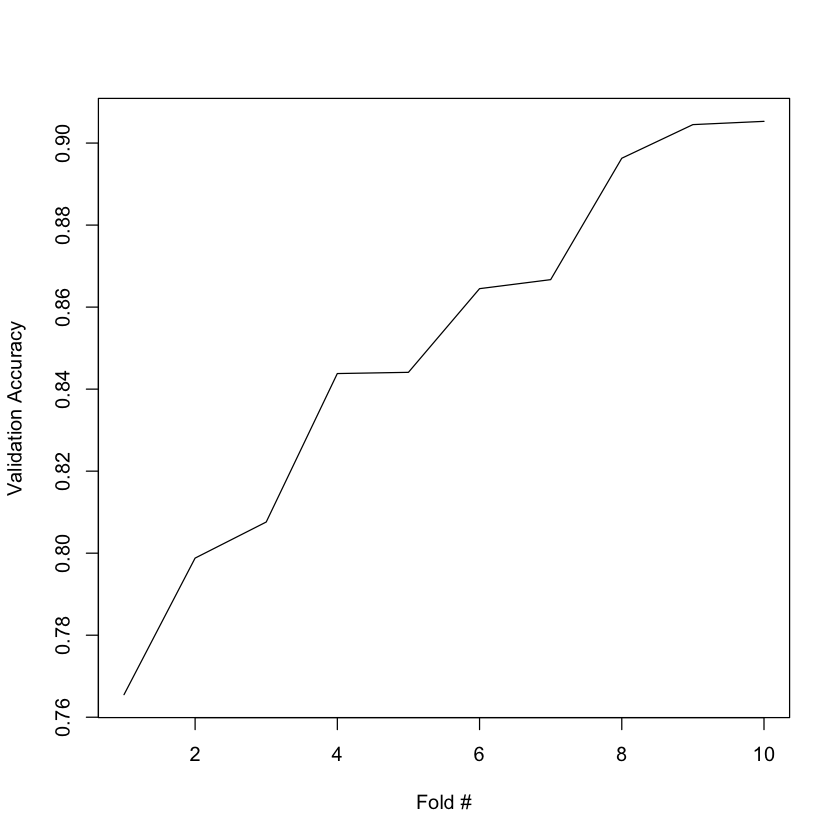

In [292]:
plot(val_acc, type = "l", xlab = "Fold #", ylab = "Validation Accuracy")

### More Training
The accuracy seems to keep impoving, should I train more?

In [290]:
for (i in 1:length(folds)){
    history = model %>% fit(
        x[-folds[[i]],], y[-folds[[i]],],
        epochs = 1,
        batch_size = 32,
        validation_data =list(x[folds[[i]],], y[folds[[i]],]),
    callbacks = list(
                callback_model_checkpoint(paste0("tweets.h5"), save_best_only = TRUE),
                callback_early_stopping(monitor = "val_loss", min_delta = 0, patience = 0,
                                        verbose = 0, mode = c("auto", "min", "max"))
        )
    )
    history
}

In [293]:
val_acc = c(val_acc,0.9135,0.9287,0.9277,0.9512,0.9456, 0.9541, 0.9507, 0.9631, 0.9564, 0.9541)

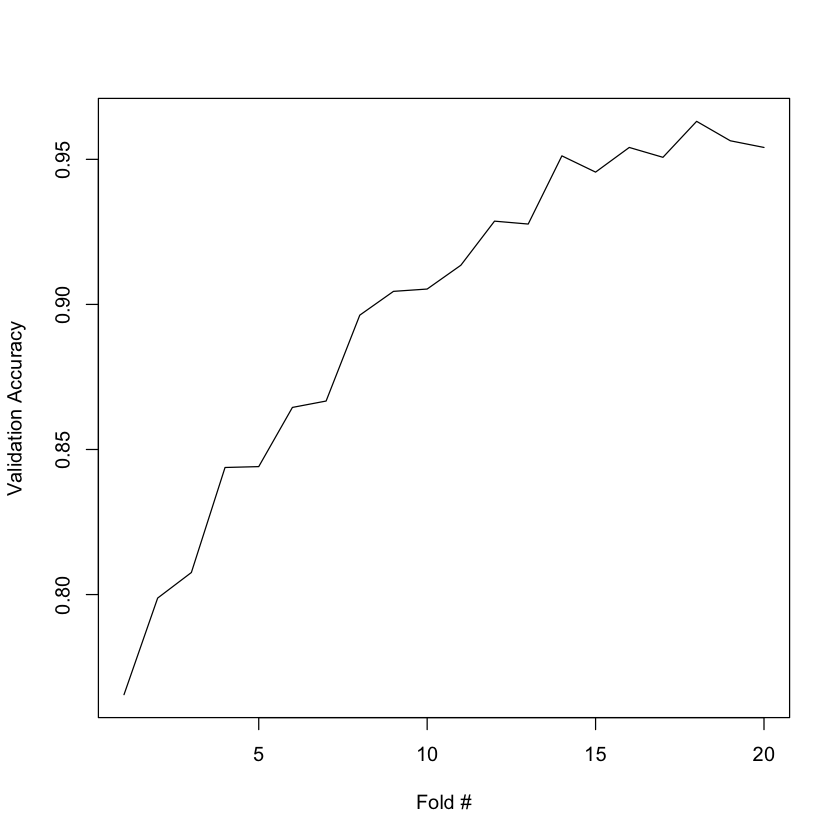

In [294]:
plot(val_acc, type = "l", xlab = "Fold #", ylab = "Validation Accuracy")

In [295]:
model = load_model_hdf5(paste0("tweets.h5"))

In [317]:
model %>% evaluate(x, y, batch_size = 32)

$loss
[1] 0.07522166

$acc
[1] 0.9745627

In [307]:
pred = model %>% 
predict(x, batch_size = 512)

In [310]:
dim(pred)[1]

[1] 8937

In [311]:
which.max(pred[1,])

[1] 1

In [308]:
head(pred)

9.952322e-01,0.007976501,0.002444212
2.628332e-05,0.003137907,0.997609258
2.188160e-02,0.015537162,0.973378181
9.230276e-01,0.063325249,0.025972588
3.679925e-03,0.006391415,0.988445640
7.461291e-06,0.999225259,0.000515473


In [312]:
pred_classes = c()
for (i in 1:dim(pred)[1]){
    pred_classes = c(pred_classes, which.max(pred[i,]))
}

In [313]:
head(pred_classes)

[1] 1 3 3 1 3 2

In [314]:
y_classes = c()
for (i in 1:dim(y)[1]){
    y_classes = c(y_classes, which.max(y[i,]))
}

In [316]:
head(y_classes)

[1] 1 3 3 1 3 2

In [321]:
confusionMatrix(data = factor(pred_classes), reference = factor(y_classes), mode = "prec_recall")

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3
         1  551   24    5
         2   16 5268  190
         3    3   97 2783

Overall Statistics
                                          
               Accuracy : 0.9625          
                 95% CI : (0.9584, 0.9664)
    No Information Rate : 0.603           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9278          
 Mcnemar's Test P-Value : 4.667e-07       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3
Precision             0.95000   0.9624   0.9653
Recall                0.96667   0.9775   0.9345
F1                    0.95826   0.9699   0.9497
Prevalence            0.06378   0.6030   0.3332
Detection Rate        0.06165   0.5895   0.3114
Detection Prevalence  0.06490   0.6125   0.3226
Balanced Accuracy     0.98160   0.9597   0.9589